In [1]:
import os
import librosa
import librosa.display
import librosa.effects
import librosa.util
# also check you can import numpy and matplotlib, which are part of the␣ 􏰀→anaconda package
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [6]:
import IPython.display as ipd

# adapted from Assignment 1
def plot_melspectrogram(wav, sr, annotations=None, n_mels=256, fmax=4096):
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    M = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax, fmax=fmax)
    ax.set(title='Mel spectrogram display')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x,y,text in annotations:
            ax.annotate(
                text,
                xy=(x,y), xycoords='data',
                xytext=(10, -50), textcoords='offset pixels',
                horizontalalignment='right',
                color='white',
                fontsize=20,
                verticalalignment='bottom',
                arrowprops=dict(
                    arrowstyle= '-|>',
                    color='white',
                     lw=1,
                     ls='-')
            )
    

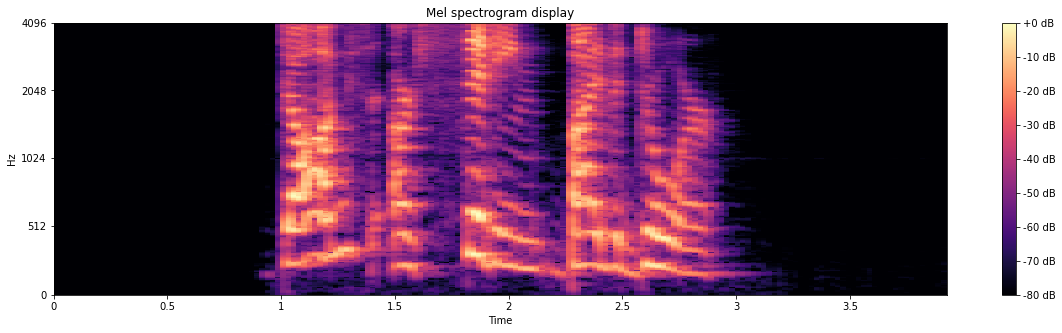

In [13]:
wav_dir = 'Audio_Speech_Actors_01-24'

for directory in os.listdir(wav_dir):
    if os.path.isdir(os.path.join(wav_dir, directory)):
        for filename in os.listdir(os.path.join(wav_dir, directory)):
            if filename.endswith(".wav"):
                wav, sr = librosa.load(os.path.join(wav_dir, directory, filename))
                plot_melspectrogram(wav, sr)
                break
    break

In [20]:
from collections import defaultdict
from time import process_time

N_FFT = 2048
FMAX = 4096
HOP_LENGTH = 512

data = defaultdict(list)

start = process_time()
for directory in os.listdir(wav_dir):
    if os.path.isdir(os.path.join(wav_dir, directory)):
        for filename in os.listdir(os.path.join(wav_dir, directory)):
            if filename.endswith(".wav"):
                wav, sr = librosa.load(os.path.join(wav_dir, directory, filename))
                data['mel'].append(librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=256, fmax=FMAX, n_fft=N_FFT))
                data['mfcc'].append(librosa.feature.mfcc(wav, hop_length=HOP_LENGTH, n_mfcc=20, fmax=FMAX))
                data['chromagram'].append(librosa.feature.chroma_stft(wav, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT))
                data['spec_contrast'].append(librosa.feature.spectral_contrast(y=wav, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)) #stft here instead of wav??
                data['tonnetz'].append(librosa.feature.tonnetz(y=librosa.effects.harmonic(wav), sr=sr))
                
                data['filename'].append(filename)
                
                # parse filename
                identifiers = filename.split('-')
                emotion = int(identifiers[2])
                intensity = int(identifiers[3])
                statement = int(identifiers[4])
                repeat = int(identifiers[5])
                gender = int(identifiers[6][:2]) % 2
                data['emotion'].append(emotion)
                data['intensity'].append(intensity)
                data['statement'].append(statement)
                data['repeat'].append(repeat)
                data['gender'].append(gender)
end = process_time()

print("elapsed " + str(end-start) + " seconds")

elapsed 569.7565780000001 seconds


In [21]:
f = open("preprocessed_data_02_27.pkl", "wb")
pickle.dump(data, f)
f.close()

In [2]:
f = open("preprocessed_data_02_27.pkl", "rb")
data = pickle.load(f)
f.close()
print(data.keys())

dict_keys(['M', 'mfcc', 'chromagram', 'filename'])


In [6]:
for filename in data['filename']:
    identifiers = filename.split('-')
    emotion = int(identifiers[2])
    intensity = int(identifiers[3])
    statement = int(identifiers[4])
    repeat = int(identifiers[5])
    gender = int(identifiers[6][:-4]) % 2
    data['emotion'].append(emotion)
    data['intensity'].append(intensity)
    data['statement'].append(statement)
    data['repeat'].append(repeat)
    data['gender'].append(gender)
    
f = open("preprocessed_data_02_28.pkl", "wb")
pickle.dump(data, f)
f.close()

In [7]:
import pandas as pd

df = pd.concat([
    pd.DataFrame(data['emotion']),
    pd.DataFrame(data['intensity']),
    pd.DataFrame(data['statement']),
    pd.DataFrame(data['repeat']),
    pd.DataFrame(data['gender']), 
    pd.DataFrame(data['mel']),
    pd.DataFrame(data['mfcc']),
    pd.DataFrame(data['chromagram']),
    pd.DataFrame(data['spec_contrast']),
    pd.DataFrame(data['tonnetz']),
    pd.DataFrame(data['filename'])
], axis=1)

df.columns = ['emotion', 'intensity', 'statement', 'repeat', 'gender', 'mel', 'mfcc', 'chromagram', 'spec_contrast', 'tonnetz', 'filename']

/Users/justinwang/anaconda3/envs/cs224s/lib/python3.7/site-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [8]:
df.head()
temp = df.dropna()
print(len(df), len(temp))

1440 1440


In [9]:
#split dataset into train (80%) and val_test (20%) then split val_test half and half for val and test sets
train, val_test = train_test_split(temp, test_size=0.2, random_state=42, 
                                                    stratify=temp[['emotion', 'intensity', 'statement', 'repeat', 'gender']])
val, test = train_test_split(val_test, test_size=0.5, random_state=42, 
                                                    stratify=temp[['emotion', 'intensity', 'statement', 'repeat', 'gender']])

In [10]:
train.head()

,emotion,intensity,statement,repeat,gender,M,mfcc,chromagram,filename
353,5,2,1,1,1,"[[2.4188818e-08, 0.00027931613, 0.00025299736,...","[[-583.9095, -583.0976, -583.4289, -583.73706,...","[[0.429417, 0.62604487, 0.5763703, 0.6709725, ...",03-01-05-02-01-01-19.wav
54,8,2,1,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-683.0082, -683.0082, -683.0082, -683.0082, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-08-02-01-01-16.wav
521,1,1,2,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-888.6226, -888.6226, -888.6226, -888.6226, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-01-01-02-01-04.wav
39,5,2,1,2,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-568.82874, -568.82874, -568.82874, -568.828...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-05-02-01-02-16.wav
459,7,1,1,2,1,"[[1.7927633e-07, 4.4093726e-05, 9.371469e-05, ...","[[-730.6004, -727.8102, -725.2224, -725.0539, ...","[[0.4719292, 0.49101898, 0.59727097, 0.4086207...",03-01-07-01-01-02-17.wav


In [11]:
f = open("preprocessed_data_split_nona_02_28.pkl", "wb")
pickle.dump((train, val, test), f)
f.close()

In [12]:
f = open("preprocessed_data_split_nona_02_28.pkl", "rb")
train, val, test = pickle.load(f)
f.close()

array([[<AxesSubplot:title={'center':'emotion'}>]], dtype=object)

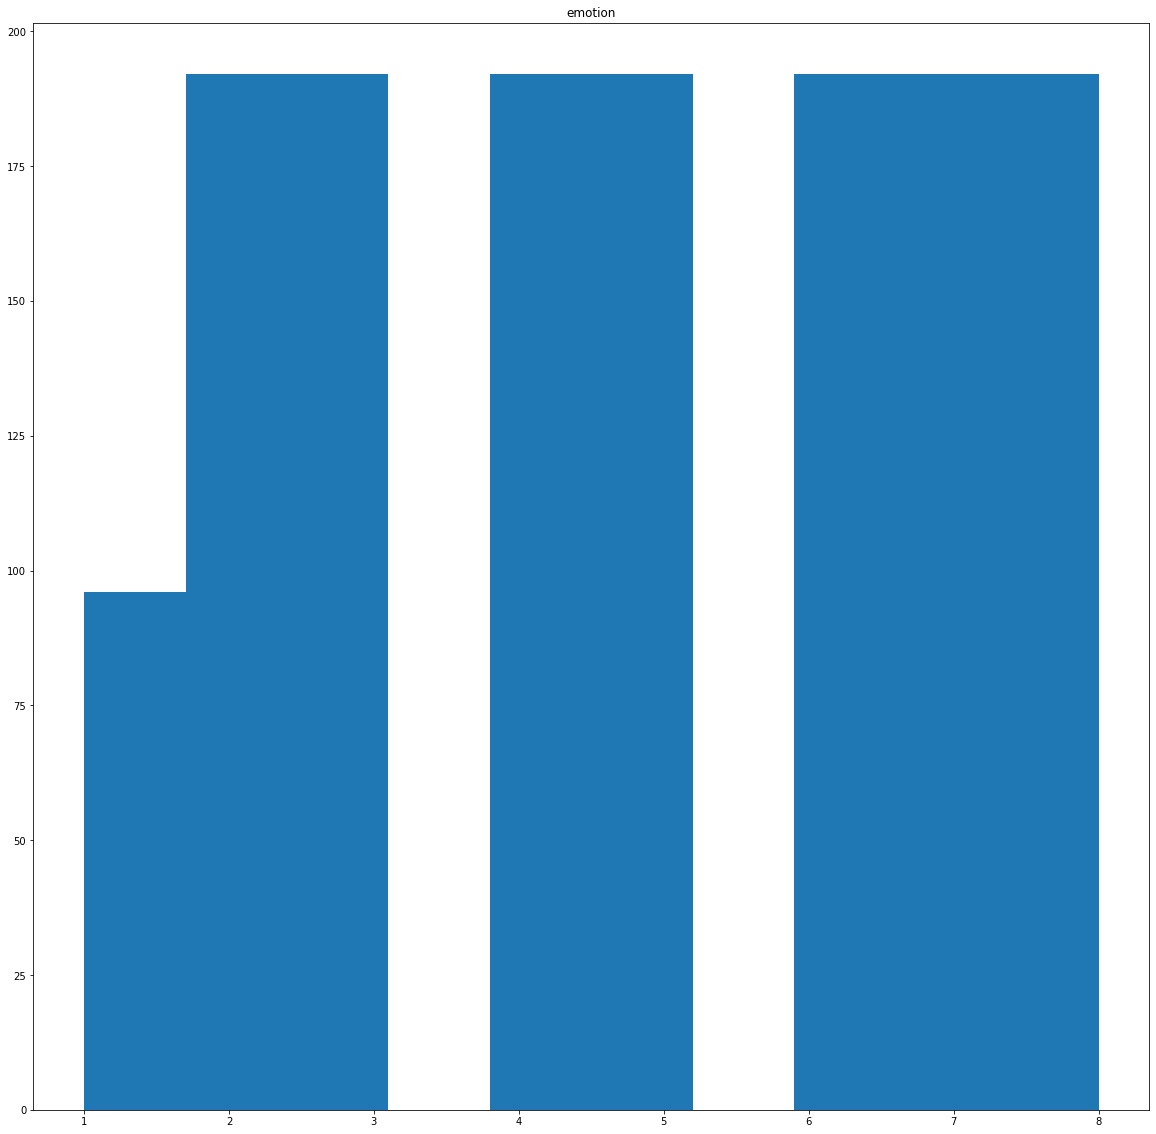

In [20]:
temp.hist(figsize=(20,20), grid=False, column=['emotion'])
labels = ("neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised")
plt.xticks(positions, labels)

In [27]:
df_eda = pd.concat([
    pd.DataFrame(data['emotion']).replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}),
    pd.DataFrame(data['intensity']).replace({1: 'normal', 2:'strong'}),
    pd.DataFrame(data['statement']).replace({1: 'kids', 2: 'dogs'}),
    pd.DataFrame(data['repeat']),
    pd.DataFrame(data['gender']).replace({0: 'female', 1: 'male'}), 
    pd.DataFrame(data['mel']),
    pd.DataFrame(data['mfcc']),
    pd.DataFrame(data['chromagram']),
    pd.DataFrame(data['filename'])
], axis=1)

df_eda = df_eda.dropna()
df_eda.columns = ['emotion', 'intensity', 'statement', 'repeat', 'gender', 'mel', 'mfcc', 'chromagram', 'filename']
print(len(df_eda))

1440


/Users/justinwang/anaconda3/envs/cs224s/lib/python3.7/site-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [28]:
df_eda.head()

,emotion,intensity,statement,repeat,gender,M,mfcc,chromagram,filename
0,angry,normal,dogs,1,female,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-719.10425, -719.10425, -719.10425, -719.104...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-05-01-02-01-16.wav
1,fear,normal,dogs,2,female,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-683.83325, -683.83325, -683.83325, -683.833...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-06-01-02-02-16.wav
2,fear,strong,kids,2,female,"[[1.5215503e-06, 7.7424994e-07, 4.0552598e-07,...","[[-551.57367, -551.57367, -551.57367, -551.573...","[[0.7882186, 0.7101846, 0.6173717, 0.6178172, ...",03-01-06-02-01-02-16.wav
3,angry,strong,kids,1,female,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-572.2166, -572.2166, -572.2166, -572.2166, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-05-02-01-01-16.wav
4,disgust,normal,kids,1,female,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-819.2477, -819.2477, -819.2477, -819.2477, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",03-01-07-01-01-01-16.wav


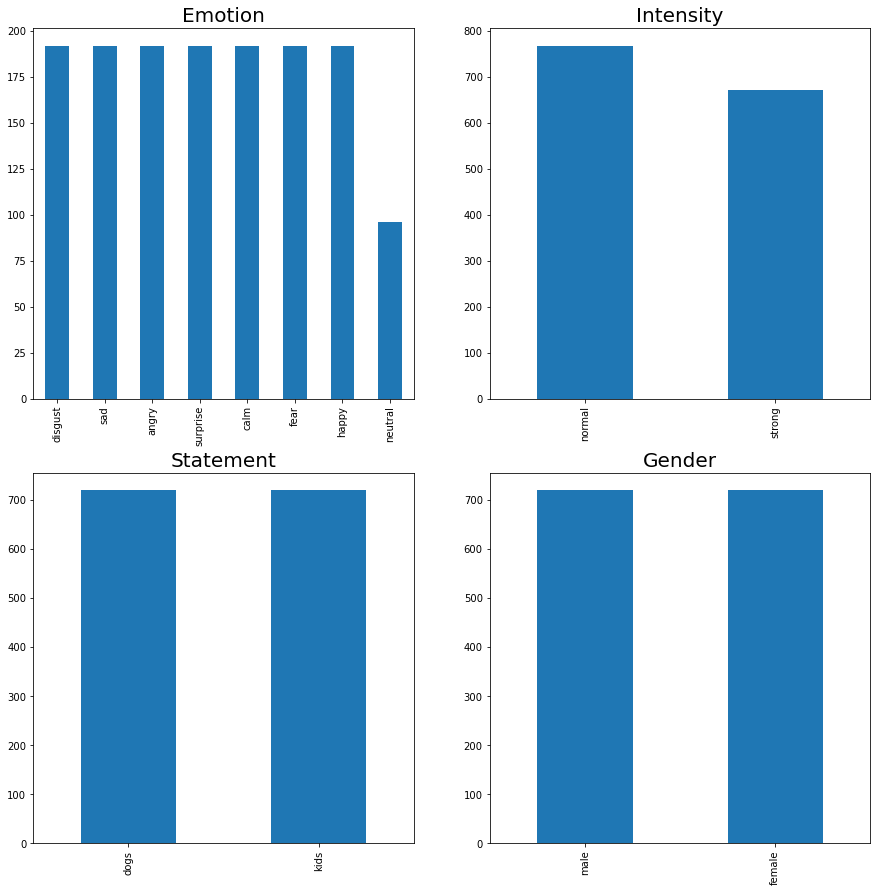

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
df_eda['emotion'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title("Emotion")
ax1.title.set_size(20)
df_eda['intensity'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title("Intensity")
ax2.title.set_size(20)
df_eda['statement'].value_counts().plot(ax=ax3, kind='bar')
ax3.set_title("Statement")
ax3.title.set_size(20)
df_eda['gender'].value_counts().plot(ax=ax4, kind='bar')
ax4.set_title("Gender")
ax4.title.set_size(20)
plt.savefig("eda.png")

Text(0.5, 1.0, 'Intensity')

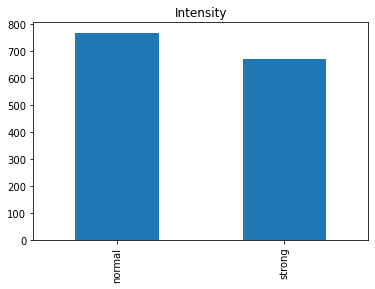

In [43]:
df_eda['intensity'].value_counts().plot(kind='bar')
plt.title("Intensity")
plt.savefig("intensity.png")

Text(0.5, 1.0, 'Statement')

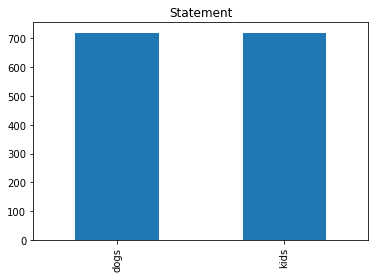

In [44]:
df_eda['statement'].value_counts().plot(kind='bar')
plt.title("Statement")
plt.savefig("statement.png")

Text(0.5, 1.0, 'Repeat #')

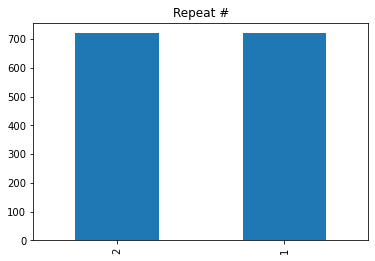

In [50]:
df_eda['repeat'].value_counts().plot(kind='bar')
plt.title("Repeat #")
plt.savefig("repeat.png")

Text(0.5, 1.0, 'Gender')

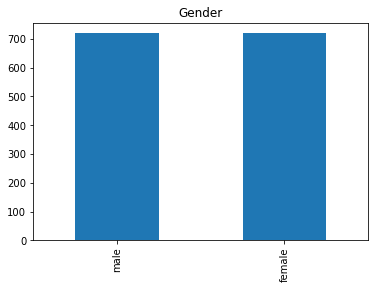

In [46]:
df_eda['gender'].value_counts().plot(kind='bar')
plt.title("Gender")